## 1. Подберите параметры алгоритма разрастания регионов так, чтобы был выделен весь участок газона

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

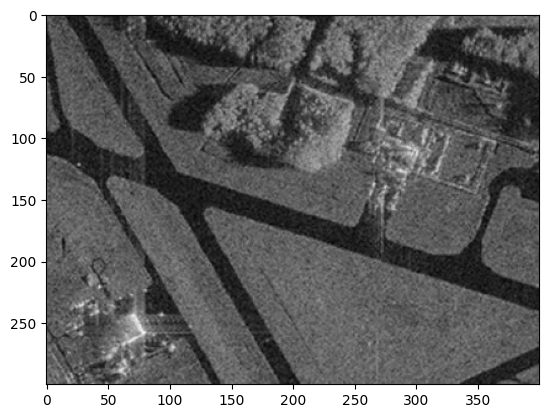

In [ ]:
plt.imshow(image_gray, cmap="gray")

In [ ]:
import math
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
    if abs(av_val - img[point]) <= T:
        return True
    return False

In [ ]:
def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i, j] == 0 and mask[i - r:i + r, j - r:j +
                r].sum() > 0:
                    if homo_fun(image, mask, (i, j), T):
                        local_mask[i, j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask
    return mask * 255

In [ ]:
seed_point = (250, 250)
mask = region_growing(image_gray, seed_point, homo_average, 5, 18)

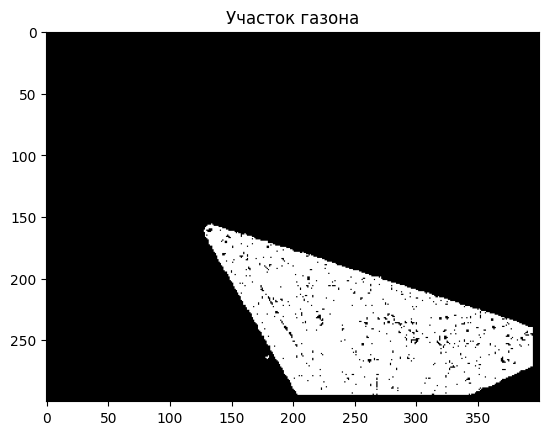

In [ ]:
plt.imshow(mask, cmap="gray")
plt.title("Участок газона")
plt.show()

## 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты

In [ ]:
flags = cv2.KMEANS_RANDOM_CENTERS
z = image_gray.reshape((-1,3))
z = np.float32(z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

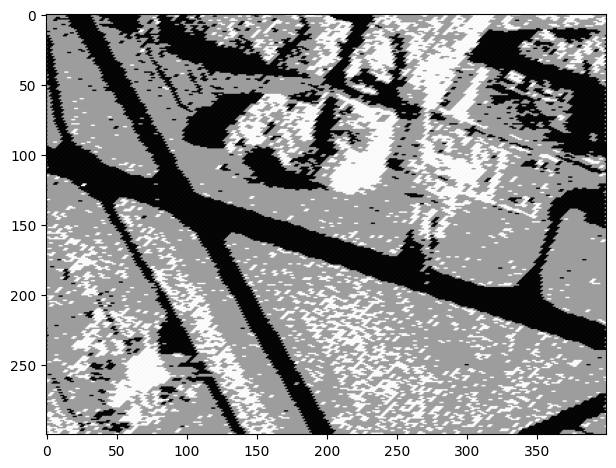

In [ ]:
K = 3
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image_gray.shape))

plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.imshow(res2, cmap="gray")

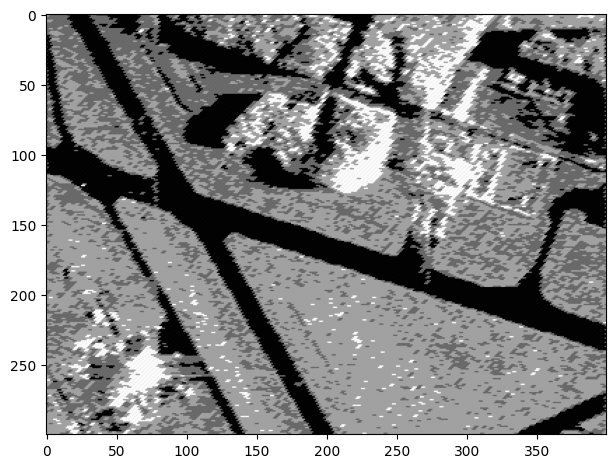

In [ ]:
K = 4
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image_gray.shape))

plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.imshow(res2, cmap="gray")

## Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев

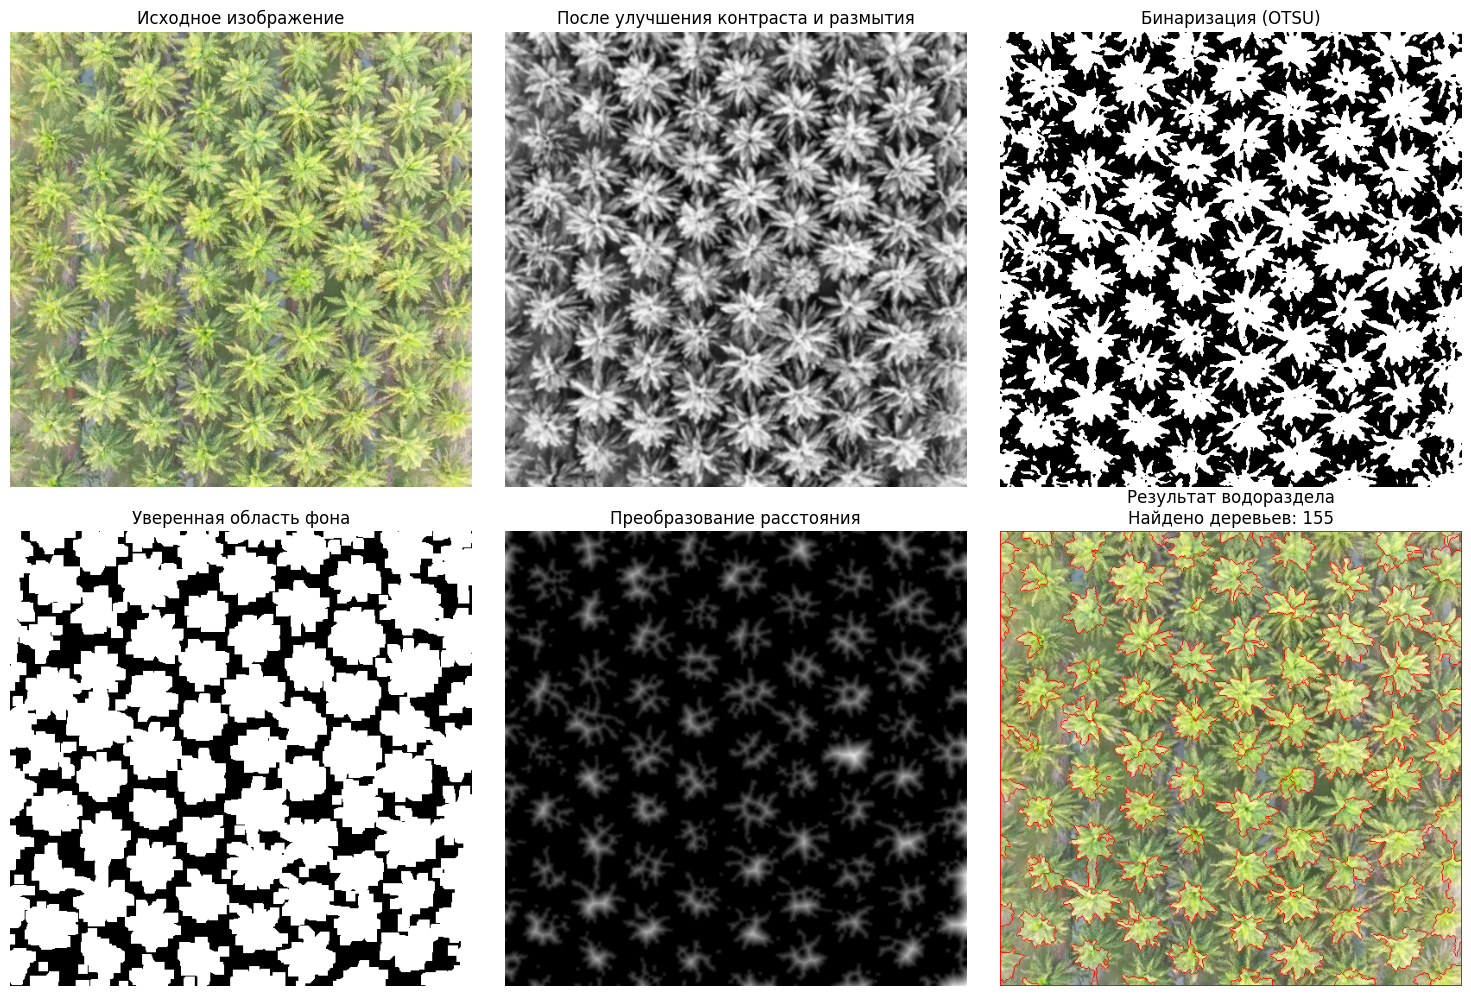

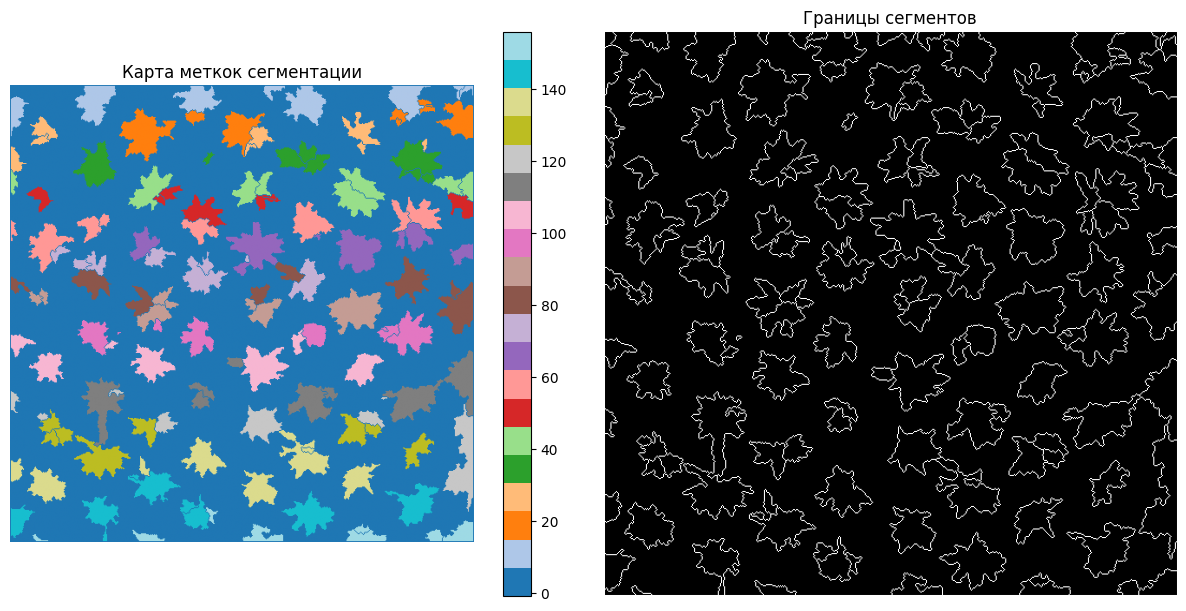

Количество обнаруженных пальмовых деревьев: 155


In [ ]:
image1 = cv2.imread('palm_1.jpg')
image_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image_gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(image_rgb)
plt.title('Исходное изображение')
plt.axis('off')


clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
image_enhanced = clahe.apply(image_gray1)


blurred = cv2.GaussianBlur(image_enhanced, (5, 5), 0)

plt.subplot(2, 3, 2)
plt.imshow(blurred, cmap='gray')
plt.title('После улучшения контраста и размытия')
plt.axis('off')


ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.subplot(2, 3, 3)
plt.imshow(thresh, cmap='gray')
plt.title('Бинаризация (OTSU)')
plt.axis('off')


kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)


sure_bg = cv2.dilate(opening, kernel, iterations=3)

plt.subplot(2, 3, 4)
plt.imshow(sure_bg, cmap='gray')
plt.title('Уверенная область фона')
plt.axis('off')


dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_transform.max(), 255, 0)

plt.subplot(2, 3, 5)
plt.imshow(dist_transform, cmap='gray')
plt.title('Преобразование расстояния')
plt.axis('off')


sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)


ret, markers = cv2.connectedComponents(sure_fg)


markers = markers + 1


markers[unknown == 255] = 0


markers = cv2.watershed(image_rgb, markers)


result_image = image_rgb.copy()
result_image[markers == -1] = [255, 0, 0]  


unique_markers = np.unique(markers)
tree_count = len(unique_markers) - 2  

plt.subplot(2, 3, 6)
plt.imshow(result_image)
plt.title(f'Результат водораздела\nНайдено деревьев: {tree_count}')
plt.axis('off')

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.imshow(markers, cmap='tab20')
plt.title('Карта меткок сегментации')
plt.colorbar()
plt.axis('off')


plt.subplot(1, 2, 2)
boundaries = np.zeros_like(image_gray1)
boundaries[markers == -1] = 255
plt.imshow(boundaries, cmap='gray')
plt.title('Границы сегментов')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Количество обнаруженных пальмовых деревьев: {tree_count}")